Importing all the necessary modules, with the usual aliases. See readme for graphviz ImportError resolution.

In [54]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14.0, 12.0]

For some reason Python converts some of the columns to type = Object, so here I'm forcing them all to be numeric.

In [19]:
df = pd.read_csv('C:/PythonProjects/ThesisPy/ThesisData3.csv')
df = df.apply(pd.to_numeric, errors='coerce')

First, I'll subset the data a little bit.
Next, we need to point python at a decompiler so that xgboost will import correctly. See readme.

In [20]:
df_1 = df.loc[:,'WFT1':'FamSup']
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
df_1.shape

(414, 177)

Subsetting removes a few categorical, total-score, and transformed columns, leaving us with 414 rows of 177 columns. 
Not exactly big data, but enough for our purposes.
Next, I'll slice our new df to separate the target (outcome) variable from the feature (prediction) variables and make a
xgboost-centric data object from them.

In [21]:
X = df_1.loc[:,'WFT1':'Industry']
y = df_1.loc[:,'WF4Omni']
mydmatrix = xgb.DMatrix(data=X, label=y)

First, we'll make 10 trees using 80% of our rows, and then see how well that tree predicts our outcome on the remaining 20%.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)

xg_reg = xgb.XGBRegressor(seed=123, objective = "reg:linear", n_estimators=10)

xg_reg.fit(X_train, y_train)
preds=xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 30.137213


RMSE (our error metric) is about 30. Not great, but it's just a baseline for now. Next, we'll plot the last (10th) tree xgboost created for us.

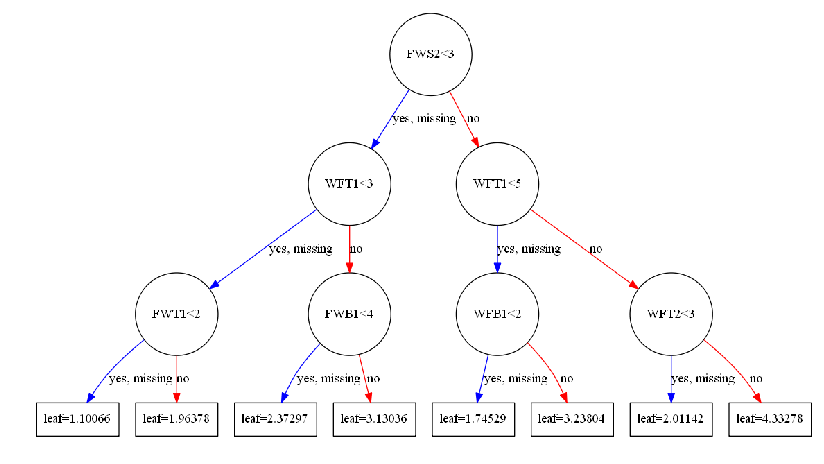

In [69]:
xgb.plot_tree(xg_reg, num_trees = 9)
plt.show()

Now to make some boosted trees. The xgboost API takes a dictionary of model parameters, and uses the DMatrix we created previously.

In [55]:
params = {"objective":"reg:linear", "max_depth":5}
xg_reg = xgb.train(params=params, dtrain=mydmatrix, num_boost_round=8)

We can plot the relative importance of the variables xgboost used to plot our trees.

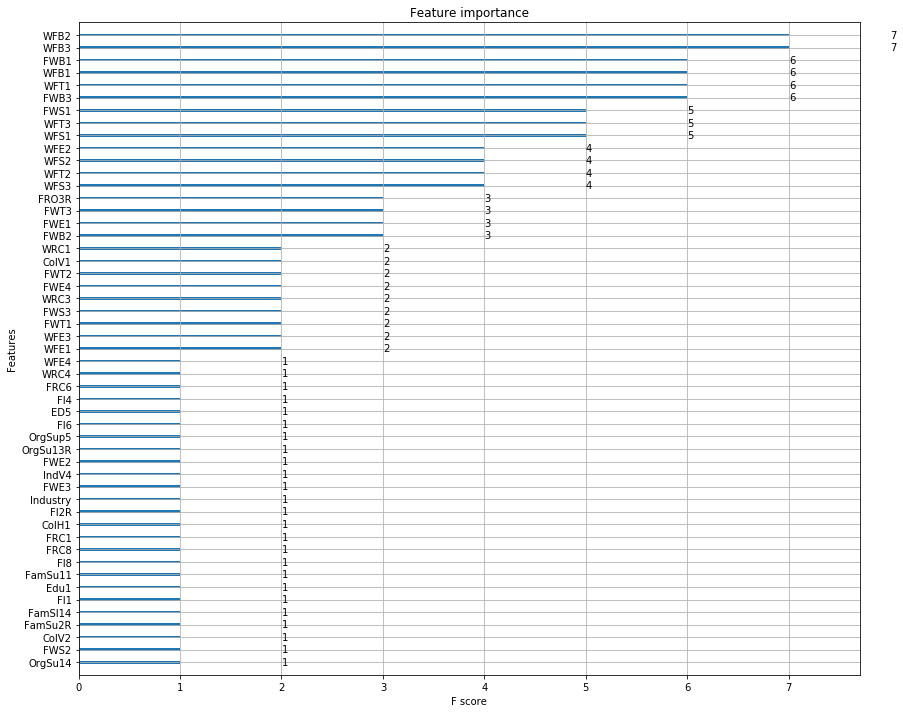

In [56]:
xgb.plot_importance(xg_reg)
plt.show()

Using graphviz, we can also plot individual trees - the second tree, in this case.

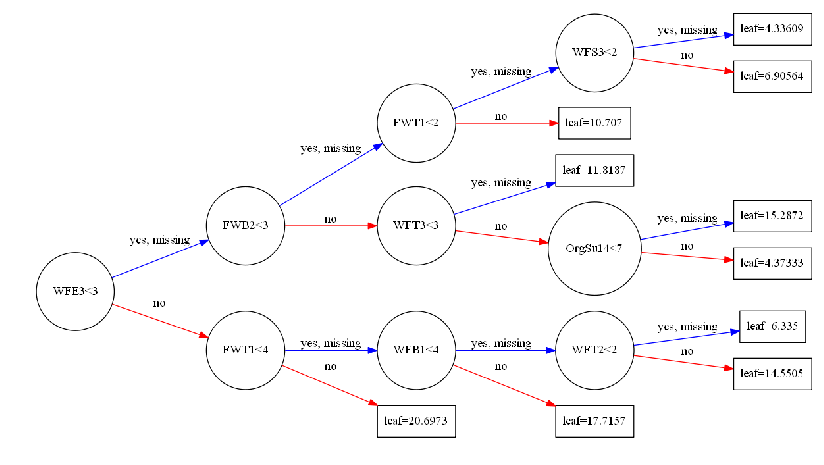

In [57]:
xgb.plot_tree(xg_reg, num_trees=1, rankdir = 'LR')
plt.show()

Now let's try some optimization and validation. We create a range of lambda values from 0.001 to 1 (really 1.001) and our xgboost parameter dictionary. Then we initialize an empty list to store our rmse values, then iterate over a for-loop to run our models. 
(10-fold x-validation and 10 trees by default here)

In [62]:
reg_params = np.arange(0.001, 1.10, 0.10)
params = {"objective":"reg:linear","max_depth":3}
rmses_l2 = []
for reg in reg_params:

    params["lambda"] = reg
    cv_results_rmse = xgb.cv(dtrain=mydmatrix, params=params, nfold=10, num_boost_round=10, metrics="rmse", 
                             as_pandas=True, seed=123)
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

In [63]:
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
       l2      rmse
0   0.001  5.899552
1   0.101  6.079757
2   0.201  6.008076
3   0.301  5.894314
4   0.401  6.228162
5   0.501  6.027791
6   0.601  6.270362
7   0.701  5.986407
8   0.801  6.173022
9   0.901  6.353287
10  1.001  6.131467


The best value of lambda here was 0.001, with an associated RMSE of 5.9. 

Here there be dragons. Testing sklearn API and further optimization. Updates to follow.

In [67]:
from sklearn.tree import DecisionTreeRegressor

In [65]:
my_dt = DecisionTreeRegressor(max_depth= 5)
my_dt.fit(X_train, y_train)
mydtpred = my_dt.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, mydtpred))
print("RMSE: %f" % (rmse))

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').